<center>
<img src="../../img/ods_stickers.jpg">


[Материал разработат на основе электронного ресурса](Ю.Кашницкого.https://mlcourse.ai/book/index.html)

# Обучение без учителя: PCA и кластеризация

Привет всем и добро пожаловать в седьмую статью нашего открытого курса машинного обучения

Данное занятие мы посвятим методам обучения без учителя (unsupervised learning), в частности методу главных компонент (PCA — principal component analysis) и кластеризации. Вы узнаете, зачем снижать размерность в данных, как это делать и какие есть способы группирования схожих наблюдений в данных.

#### Список статей серии
1. [Первичный анализ данных с Pandas](https://habrahabr.ru/company/ods/blog/322626/)
2. [Визуальный анализ данных c Python](https://habrahabr.ru/company/ods/blog/323210/)
3. [Классификация, деревья решений и метод ближайших соседей](https://habrahabr.ru/company/ods/blog/322534/)
4. [Линейные модели классификации и регрессии](https://habrahabr.ru/company/ods/blog/323890/)
5. [Композиции: бэггинг, случайный лес. Кривые валидации и обучения](https://habrahabr.ru/company/ods/blog/324402/)
6. [Построение и отбор признаков](https://habrahabr.ru/company/ods/blog/325422/)
7. [Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)


### План этой статьи

1. Метод главных компонент (PCA)
 - Интуиция, теория и особенности применения
 - Примеры использования
2. Кластеризация
 - K-means
 - Affinity Propagation
 - Спектральная кластеризация
 - Агломеративная кластеризация
 - Метрики качества кластеризации
4. Полезные источники

## Введение

Основное отличие методов обучения без учителя от привычных классификаций и регрессий машинного обучения в том, что разметки для данных в этом случае нет. От этого образуются сразу несколько особенностей — во-первых это возможность использования несопоставимо больших объёмов данных, поскольку их не нужно будет размечать руками для обучения, а во-вторых это неясность измерения качества методов, из-за отсутствия таких же прямолинейных и интуитивно понятных метрик, как в задачах обучения с учителем.

Одной из самых очевидных задач, которые возникают в голове в отсутствие явной разметки, является задача снижения размерности данных. С одной стороны её можно рассматривать как помощь в визуализации данных, для этого часто используется метод t-SNE, который мы рассмотрели во второй статье курса. С другой стороны подобное снижение размерности может убрать лишние сильно скоррелированные признаки у наблюдений и подготовить данные для дальнейшей обработки в режиме обучения с учителем, например сделать входные данные более "перевариваемыми" для деревьев решений.

## 1. Метод главных компонент (PCA)

### Интуиция, теория и особенности применения

Метод главных компонент (Principal Component Analysis) — один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков.

<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">

В совсем общем виде это можно представить как предположение о том, что все наши наблюдения скорее всего выглядят как некий эллипсоид в подпространстве нашего исходного пространства и наш новый базис в этом пространстве совпадает с осями этого эллипсоида. Это предположение позволяет нам одновременно избавиться от сильно скоррелированных признаков, так как вектора базиса пространства, на которое мы проецируем, будут ортогональными.

В общем случае размерность этого эллипсоида будет равна размерности исходного пространства, но наше предположение о том, что данные лежат в подпространстве меньшей размерности, позволяет нам отбросить "лишнее" подпространство в новой проекции, а именно то подпространство, вдоль осей которого эллипсоид будет наименее растянут. Мы будем это делать "жадно", выбирая по-очереди в качестве нового элемента базиса нашего нового подпространства последовательно ось эллипсоида из оставшихся, вдоль которой дисперсия будет максимальной.

> "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." - Geoffrey Hinton

Рассмотрим как это делается математически:

Чтобы снизить размерность наших данных из $n$ в $k, k \leq n$, нам нужно выбрать топ-$k$ осей такого эллипсоида, отсортированные по убыванию по дисперсии вдоль осей.

Начнём с того, что посчитаем дисперсии и ковариации исходных признаков. Это делается просто с помощью матрицы ковариации. По определению ковариации, для двух признаков $X_i$ и $X_j$ их ковариация будет 
$$cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j$$
где $\mu_i$ — матожидание $i$-ого признака.
При этом отметим, что ковариация симметрична и ковариация вектора с самим собой будет равна его дисперсии.

Таким образом матрица ковариации представляет собой симметричную матрицу, где на диагонали лежат дисперсии соответствующих признаков, а вне диагонали — ковариации соответствующих пар признаков. В матричном виде, где $\mathbf{X}$ это матрица наблюдений, наша матрица ковариации будет выглядеть как
$$\Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}]$$

Чтобы освежить память — у матриц как у линейных операторов есть такое интересное свойство как собственные значения и собственные вектора (eigenvalues и eigenvectors). Эти штуки замечательны тем, что когда мы нашей матрицей действуем на соответствующее линейное пространство, собственные вектора остаются на месте и лишь умножаются на соответствующие им собственные значения. То есть определяют подпространство, которое при действии этой матрицей как линейным оператором, остаётся на месте или "переходит в себя". Формально собственный вектор $w_i$ с собственным значением $\lambda_i$ для матрицы $M$ определяется просто как $M w_i = \lambda_i w_i$.

Матрицу ковариации для нашей выборки $\mathbf{X}$ можно представить в виде произведения $\mathbf{X}^{T} \mathbf{X}$. Из [отношения Релея](https://ru.wikipedia.org/wiki/%D0%9E%D1%82%D0%BD%D0%BE%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A0%D1%8D%D0%BB%D0%B5%D1%8F) вытекает, что максимальная вариация нашего набора данных будет достигаться вдоль собственного вектора этой матрицы, соответствующего максимальному собственному значению. Таким образом главные компоненты, на которые мы бы хотели спроецировать наши данные, являются просто собственными векторами соответствующих топ-$k$ штук собственных значений этой матрицы.

Дальнейшие шаги просты до безобразия — надо просто умножить нашу матрицу данных на эти компоненты и мы получим проекцию наших данных в ортогональном базисе этих компонент. Теперь если мы транспонируем нашу матрицу данных и матрицу векторов главных компонент, мы восстановим исходную выборку в том пространстве, из которого мы делали проекцию на компоненты. Если количество компонент было меньше размерности исходного пространства, мы потеряем часть информации при таком преобразовании.

## Примеры использования
### Набор данных по цветкам ириса
Начнём с того, что загрузим все необходимые модули и покрутим привычный датасет с ирисами по примеру из документации пакета scikit-learn.

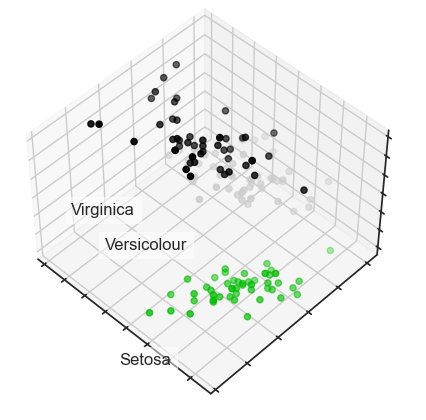

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import decomposition  # Add this import

sns.set(style="white")
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

# Загрузим наши ириски
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Заведём красивую трёхмерную картинку
fig = plt.figure(1, figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')  # Более современный способ создания 3D осей
ax.view_init(elev=48, azim=134)  # Устанавливаем углы обзора

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )

# Поменяем порядок цветов меток, чтобы они соответствовали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.nipy_spectral)

# Убираем подписи делений
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

Теперь посмотрим, насколько PCA улучшит результаты для модели, которая в данном случае плохо справится с классификацией из-за того, что у неё не хватит сложности для описания данных:

In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.88889


Теперь попробуем сделать тоже самое, но с данными, для которых мы снизили размерность до 2D:

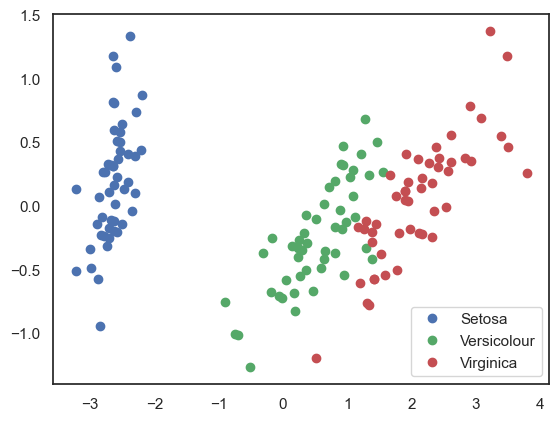

In [8]:
# Прогоним встроенный в sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], "bo", label="Setosa")
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], "go", label="Versicolour")
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], "ro", label="Virginica")
plt.legend(loc=0);

In [9]:
# Повторим то же самое разбиение на валидацию и тренировочную выборку.
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=42
)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.91111


Видно, что качество возросло незначительно, но для более сложных данных более высокой размерности, где данные не разбиваются тривиально вдоль одного признака, применение PCA может достаточно сильно улучшить качество работы деревьев решений и ансамблей на их основе.

Посмотрим на 2 главные компоненты в последнем PCA-представлении данных и на тот процент исходной дисперсии в даных, который они "объясняют".

In [10]:
for i, component in enumerate(pca.components_):
    print(
        "{} component: {}% of initial variance".format(
            i + 1, round(100 * pca.explained_variance_ratio_[i], 2)
        )
    )
    print(
        " + ".join(
            "%.3f x %s" % (value, name)
            for value, name in zip(component, iris.feature_names)
        )
    )

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### Набор данных по рукописным цифрам
Теперь возьмем набор данных по рукописным цифрам. Мы с ним уже работали в 3 [статье](https://habrahabr.ru/company/ods/blog/322534/#derevya-resheniy-i-metod-blizhayshih-sosedey-v-zadache-raspoznavaniya-rukopisnyh-cifr-mnist) про деревья решений и метод ближайших соседей.

In [11]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

Вспомним, как выглядят эти цифры – посмотрим на первые десять. Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта.

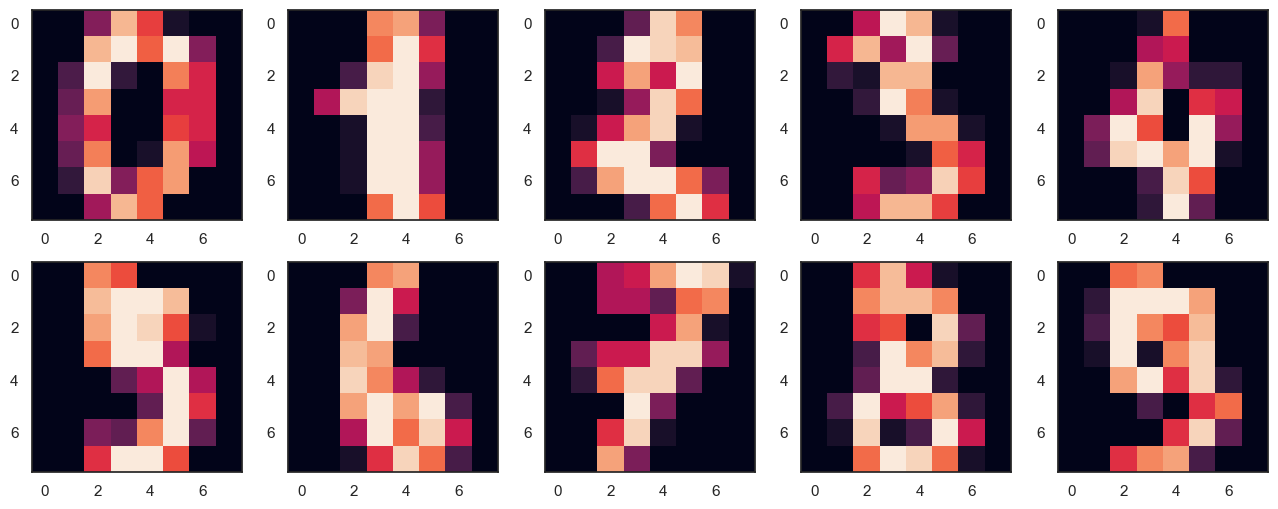

In [12]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i, :].reshape([8, 8]));

Получается, размерность признакового пространства здесь – 64. Но давайте снизим размерность всего до 2 и увидим, что даже на глаз рукописные цифры неплохо разделяются на кластеры.

Projecting 64-dimensional data to 2D


Text(0.5, 1.0, 'MNIST. PCA projection')

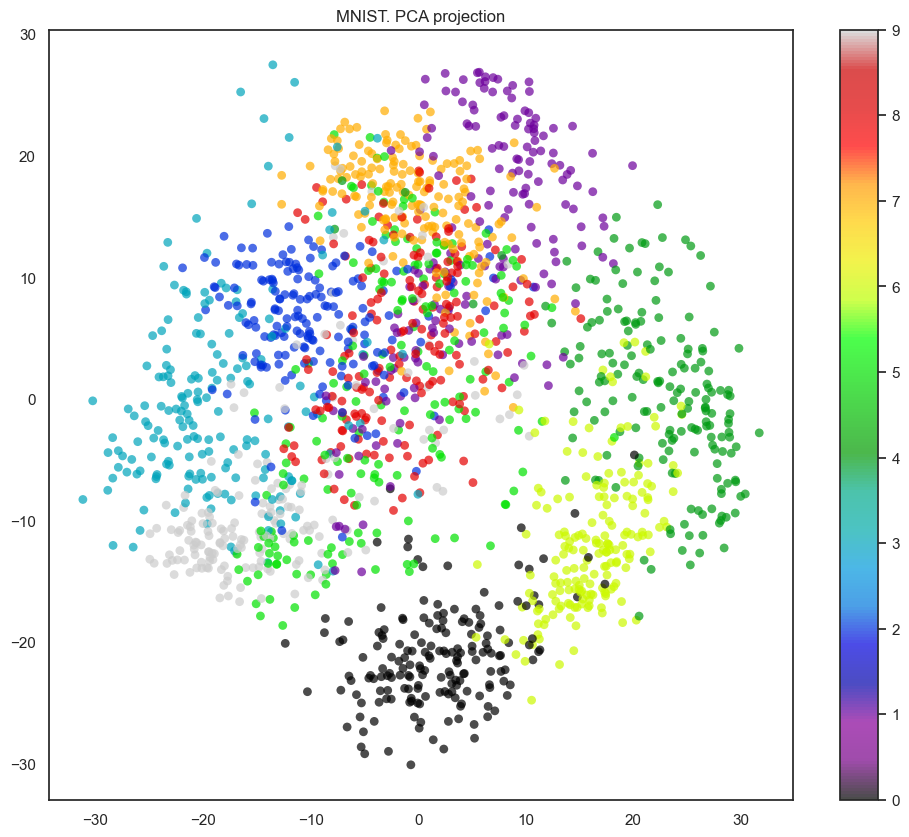

In [13]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Projecting %d-dimensional data to 2D" % X.shape[1])

plt.figure(figsize=(12, 10))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.nipy_spectral,  # Simplified version
)
plt.colorbar()
plt.title("MNIST. PCA projection")

Ну, правда, с t-SNE картинка получается еще лучше, поскольку у PCA ограничение – он находит только линейные комбинации исходных признаков. Зато даже на этом относительно небольшом наборе данных можно заметить, насколько t-SNE дольше работает.

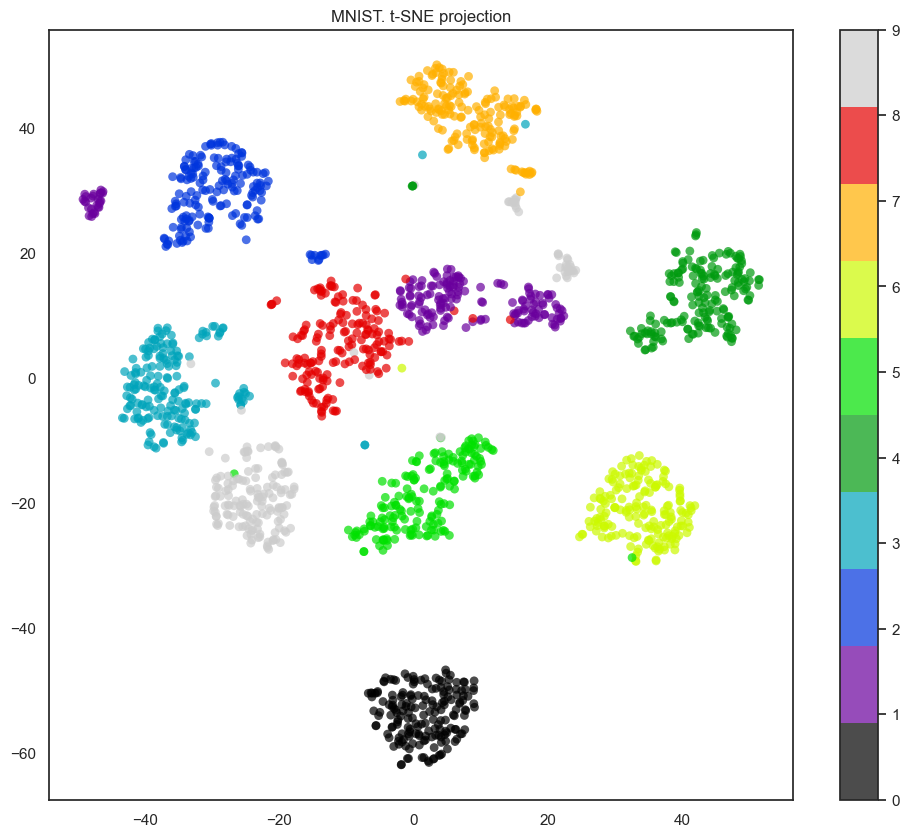

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(random_state=17)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.get_cmap("nipy_spectral", 10),  # Changed from plt.cm.get_cmap
)
plt.colorbar()
plt.title("MNIST. t-SNE projection")
plt.show()  # Added to display the plot

На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. В данном случае для этого достаточно выделить 21 главную компоненту, то есть снизить размерность с 64 признаков до 21.

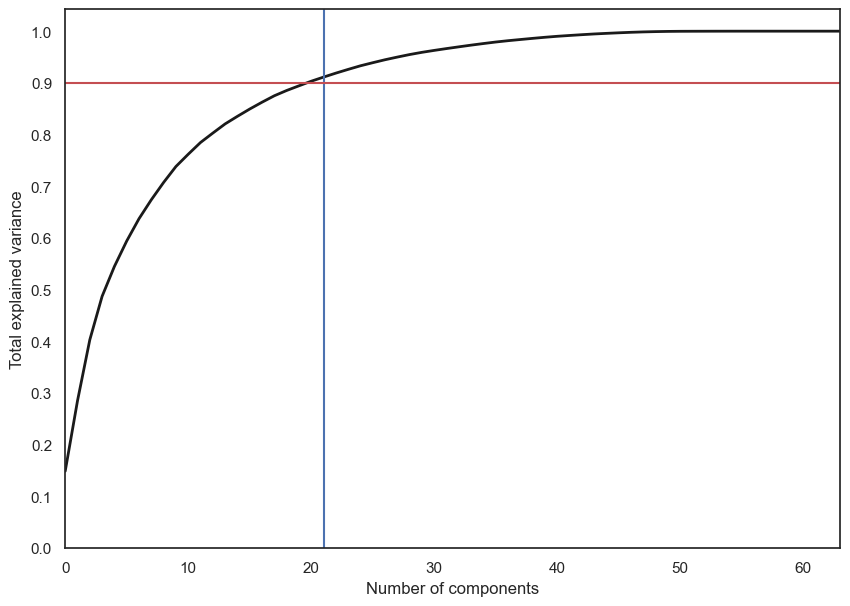

In [16]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="k", lw=2)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c="b")
plt.axhline(0.9, c="r")
plt.show();

## 2. Кластеризация

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи. Перечисленные алгоритмы ни в коем случае не описывают данное множество полностью, но являются примерами самых популярных методов решения задачи кластеризации.

<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png"><figcaption>Примеры работы алгоритмов кластеризации из документации пакета scikit-learn</figcaption></figure>

### K-means

Алгоритм К-средних, наверное, самый популярный и простой алгоритм кластеризации и очень легко представляется в виде простого псевдокода:
1. Выбрать количество кластеров $inline$k$inline$, которое нам кажется оптимальным для наших данных.
2. Высыпать случайным образом в пространство наших данных $inline$k$inline$ точек (центроидов).
3. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.
4. Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

В случае обычной евклидовой метрики для точек лежащих на плоскости, этот алгоритм очень просто расписывается аналитически и рисуется. Давайте посмотрим соответствующий пример:

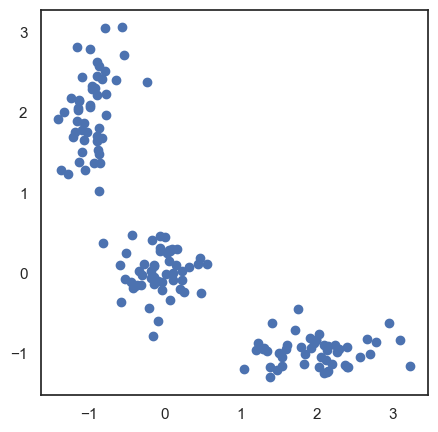

In [17]:
# Начнём с того, что насыпем на плоскость три кластера точек
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], "bo");

In [18]:
# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

# Прибьём рандомность и насыпем три случайные центроиды для начала
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1.0, size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

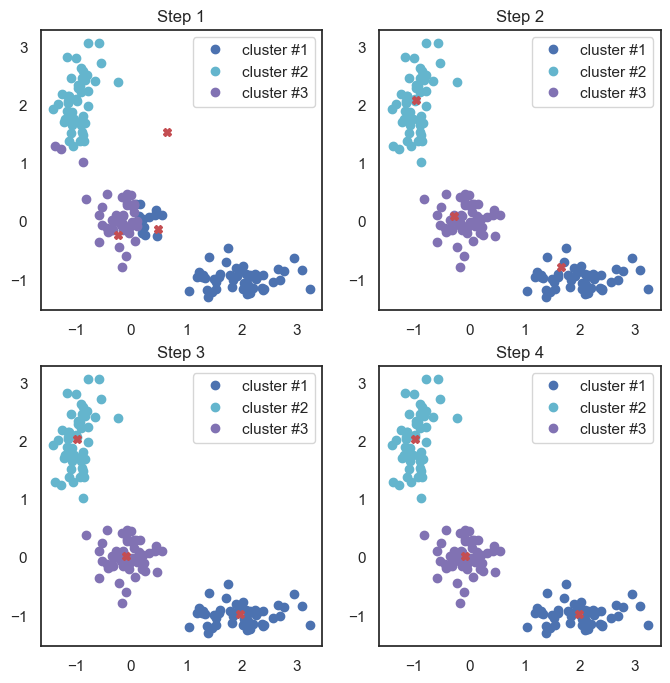

In [19]:
# А теперь нарисуем всю эту красоту
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], "bo", label="cluster #1")
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], "co", label="cluster #2")
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], "mo", label="cluster #3")
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], "rX")
    plt.legend(loc=0)
    plt.title("Step {:}".format(i + 1));

Также стоит заметить, что хоть мы и рассматривали евклидово расстояние, алгоритм будет сходиться и в случае любой другой метрики, поэтому для различных задач кластеризации в зависимости от данных можно экспериментировать не только с количеством шагов или критерием сходимости, но и с метрикой, по которой мы считаем расстояния между точками и центроидами кластеров.

Другой особенностью этого алгоритма является то, что он чувствителен к исходному положению центроид кластеров в пространстве. В такой ситуации спасает несколько последовательных запусков алгоритма с последующим усреднением полученных кластеров.

## Выбор числа кластеров для kMeans

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.
$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: 
$$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Рассмотрим пример.

In [20]:
from sklearn.cluster import KMeans

In [21]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

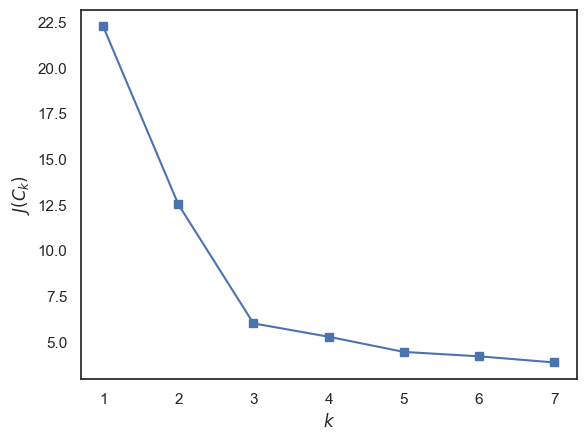

In [22]:
plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

Видим, что $J(C_k)$ падает сильно при увеличении числа кластеров с 1 до 2 и с 2 до 3 и уже не так сильно – при изменении $k$ с 3 до 4. Значит, в данной задаче оптимально задать 3 кластера.  

#### Сложности

Само по себе решение задачи K-means NP-трудное (NP-Hard, [статья](https://habrahabr.ru/post/132127/) "Еще немного про P и NP" на Хабре), и для размерности $d$, числа кластеров $k$ и числа точек $n$ решается за $O(n^{d k+1})$. Для решения такой боли часто используются эвристики, например MiniBatch K-means, который для обучения использует не весь датасет целиком, а лишь маленькие его порции (batch) и обновляет центроиды используя среднее за всю историю обновлений центроида от всех относящихся к нему точек. Сравнение обычного K-means и его MiniBatch имплементации можно посмотреть в [документации scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

[Реализация](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) алгоритма в scikit-learn обладает массой удобных плюшек, таких как возможность задать количество запусков через параметр `n_init`, что даст более устойчивые центроиды для кластеров в случае скошенных данных. К тому же эти запуски можно делать параллельно, не жертвуя временем вычисления.

## Affinity Propagation

Ещё один пример алгоритма кластеризации. В отличие от алгоритма К-средних, данный подход не требует заранее определять число кластеров на которое мы хотим разбить наши данные. Основная идея алгоритма заключается в том, что нам хотелось бы, чтобы наши наблюдения кластеризовались в группы на основе того, как они "общаются" или насколько они похожи друг на друга.

Заведём для этого какую-нибудь метрику "похожести", определяющуюся тем, что $s(x_i, x_j) > s(x_i, x_k)$ если наблюдение $x_i$ больше похоже на наблюдение $x_j$, чем на $x_k$. Простым примером такой похожести будет отрицательный квадрат расстояния $s(x_i, x_j) = - ||x_i - x_j||^{2}$.

Теперь опишем сам процесс "общения" для этого заведём две матрицы, инициализируемые нулями, одна из которых $r_{i,k}$ будет описывать насколько хорошо $k$-тое наблюдение подходит для того, чтобы быть "примером для подражания" для $i$-того наблюдения, относительно всех остальных потенциальных "примеров", а вторая — $a_{i,k}$ будет описывать насколько правильным было бы для $i$-того наблюдения выбрать $k$-тое в качестве такого "примера". Звучит немного запутанно, но чуть дальше увидим пример "на пальцах".

После этого данные матрицы обновляются по очереди по правилам:

$$r_{i,k} \leftarrow s_(x_i, x_k) - \max_{k' \neq k} \left\{ a_{i,k'} + s(x_i, x_k') \right\}$$

$$a_{i,k} \leftarrow \min \left( 0, r_{k,k} + \sum_{i' \not\in \{i,k\}} \max(0, r_{i',k}) \right), \ \ \  i \neq k$$

$$a_{k,k} \leftarrow \sum_{i' \neq k} \max(0, r_{i',k})$$

### Спектральная кластеризация
Спектральная кластеризация объединяет несколько описанных выше подходов, чтобы получить максимальное количество профита от сложных многообразий размерности меньшей исходного пространства. 

Для работы этого алгоритма нам потребуется определить матрицу похожести наблюдений (adjacency matrix). Можно это сделать таким же образом, как и для Affinity Propagation выше: $A_{i, j} = - ||x_i - x_j||^{2}$. Эта матрица также описывает полный граф с вершинами в наших наблюдениях и рёбрами между каждой парой наблюдений с весом, соответствующим степени похожести этих вершин. Для нашей выше выбранной метрики и точек, лежащих на плоскости, эта штука будет интуитивной и простой — две точки более похожи, если ребро между ними короче. Теперь нам бы хотелось разделить наш получившийся граф на две части так, чтобы получившиеся точки в двух графах были в общем больше похожи на другие точки внутри получившейся "своей" половины графа, чем на точки в "другой" половине. Формальное название такой задачи называется Normalized cuts problem и подробнее про это можно почитать [тут](http://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf).

## Алгомеративная кластеризация


Наверное самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров — агломеративная кластеризация. Интуиция у алгоритма очень простая: 
1. Начинаем с того, что высыпаем на каждую точку свой кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

Сам процесс поиска ближайших кластеров может происходить с использованием разных методов объединения точек:
1. Single linkage — минимум попарных расстояний между точками из двух кластеров
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
2. Complete linkage — максимум попарных расстояний между точками из двух кластеров
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
3. Average linkage — среднее попарных расстояний между точками из двух кластеров
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$
4. Centroid linkage — расстояние между центроидами двух кластеров
$d(C_i, C_j) = ||\mu_i - \mu_j||$

Профит первых трёх подходов по сравнению с четвёртым в том, что для них не нужно будет пересчитывать расстояния каждый раз после склеивания, что сильно снижает вычислительную сложность алгоритма.

По итогам выполнения такого алгоритма можно также построить замечательное дерево склеивания кластеров и глядя на него определить, на каком этапе нам было бы оптимальнее всего остановить алгоритм. Либо воспользоваться тем же правилом локтя, что и в k-means.

К счастью для нас в питоне уже есть замечательные инструменты для построения таких дендрограмм для агломеративной кластеризации. Рассмотрим на примере наших кластеров из K-means:

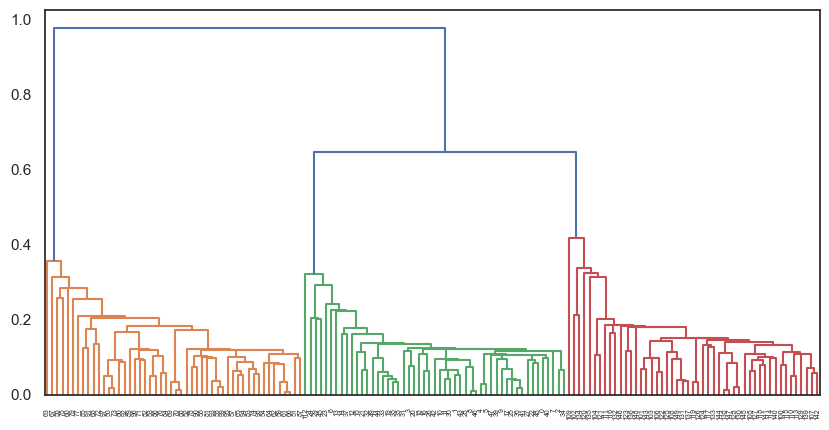

In [23]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

distance_mat = pdist(
    X
)  # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(
    distance_mat, "single"
)  # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

## Метрики качества кластеризации
Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Во-первых, такие оценки не должны зависеть от самих значений меток, а только от самого разбиения выборки. Во-вторых, не всегда известны истинные метки объектов, поэтому также нужны оценки, позволяющие оценить качество кластеризации, используя только неразмеченную выборку.

Выделяют *внешние* и *внутренние* метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.

Все указанные ниже метрики реализованы в `sklearn.metrics`.

**Adjusted Rand Index (ARI)**

Предполагается, что известны истинные метки объектов. Данная мера не зависит от самих значений меток, а только от разбиения выборки на кластеры. Пусть $N$ - число объектов в выборке. Обозначим через $a$ - число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через $b$ - число пар объектов, имеющих различные метки и находящихся в разных кластерах. Тогда Rand Index это $$\text{RI} = \frac{2(a + b)}{n(n-1)}.$$ То есть это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Rand Index (RI) выражает схожесть двух разных кластеризаций одной и той же выборки. Чтобы этот индекс давал значения близкие к нулю для случайных кластеризаций при любом $N$ и числе кластеров, необходимо нормировать его. Так определяется Adjusted Rand Index: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки. $\text{ARI}$ принимает значения в диапазоне $[-1, 1]$. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, - случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при $\text{ARI} = 1$).

**Adjusted Mutual Information (AMI)**

Данная мера очень похожа на $\text{ARI}$. Она также симетрична, не зависит от значений и перестановок меток. Определяется с использованием функции [энтропии](https://en.wikipedia.org/wiki/Entropy_(information_theory), интерпретируя разбиения выборки, как дискретные распределения (вероятность отнесения к кластеру равна доле объектов в нём). Индекс $MI$ определяется как  [взаимная информация](https://en.wikipedia.org/wiki/Mutual_information) для двух распределений, соответствующих разбиениям выборки на кластеры. Интуитивно, взаимная информация измеряет долю информации, общей для обоих разбиений: насколько информация об одном из них уменьшает неопределенность относительно другого.

Аналогично $\text{ARI}$ определяется индекс $\text{AMI}$, позволяющий избавиться от роста индекса $MI$ с увеличением числа классов. Он принимает значения в диапазоне $[0, 1]$. Значения, близкие к нулю, говорят о независимости разбиений, а близкие к единице - об их схожести (совпадении при $\text{AMI} = 1$).

**Гомогенность, полнота, V-мера**

Формально данные меры также определяются с использованием функций энтропии и условной энтропии, рассматривая разбиения выборки как дискретные распределения:$$h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac{H(K\mid C)}{H(K)},$$
здесь $K$ - результат кластеризации, $C$ - истинное разбиение выборки на классы. Таким образом, $h$ измеряет, насколько каждый кластер состоит из объектов одного класса, а $c$ - насколько объекты одного класса относятся к одному кластеру. Эти меры не являются симметричными. Обе величины принимают значения в диапазоне $[0, 1]$, и большие значения соответствуют более точной кластеризации. Эти меры не являются нормализованными, как $\text{ARI}$ или $\text{AMI}$, и поэтому зависят от числа кластеров. Случайная кластеризация не будет давать нулевые показатели при большом числе классов и малом числе объектов. В этих случаях предпочтительнее использовать $\text{ARI}$. Однако при числе объектов более 1000 и числе кластеров менее 10 данная проблема не так явно выражена и может быть проигнорирована.

Для учёта обеих величин $h$ и $c$ одновременно вводится $V$-мера, как их среднее гармоническое:
$$v = 2\frac{hc}{h+c}.$$
Она является симметричной и показывает, насколько две кластеризации схожи между собой.

**Силуэт**

В отличие от описанных выше метрик, данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$
Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

И напоследок давайте посмотрим на эти метрики для наших алгоритмов, запущенных на данных рукописных цифр MNIST:

In [24]:
import pandas as pd
from sklearn import datasets, metrics
from sklearn.cluster import (
    AffinityPropagation,
    AgglomerativeClustering,
    KMeans,
    SpectralClustering,
)

data = datasets.load_digits()
X, y = data.data, data.target

algorithms = []
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(
    SpectralClustering(n_clusters=10, random_state=1, affinity="nearest_neighbors")
)
algorithms.append(AgglomerativeClustering(n_clusters=10))

data = []
for algo in algorithms:
    algo.fit(X)
    data.append(
        (
            {
                "ARI": metrics.adjusted_rand_score(y, algo.labels_),
                "AMI": metrics.adjusted_mutual_info_score(y, algo.labels_),
                "Homogenity": metrics.homogeneity_score(y, algo.labels_),
                "Completeness": metrics.completeness_score(y, algo.labels_),
                "V-measure": metrics.v_measure_score(y, algo.labels_),
                "Silhouette": metrics.silhouette_score(X, algo.labels_),
            }
        )
    )

results = pd.DataFrame(
    data=data,
    columns=["ARI", "AMI", "Homogenity", "Completeness", "V-measure", "Silhouette"],
    index=["K-means", "Affinity", "Spectral", "Agglomerative"],
)

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.666618,0.741068,0.741543,0.745751,0.743641,0.176213
Affinity,0.174871,0.612364,0.958899,0.486801,0.645767,0.115161
Spectral,0.756461,0.852040,0.831691,0.876614,0.853562,0.182729
Agglomerative,0.794003,0.866832,0.857513,0.879096,0.868170,0.178497


## 4. Полезные источники
- [статья](https://habrahabr.ru/company/io/blog/265089/) "Как подобрать платье с помощью метода главных компонент"
- [статья](https://habrahabr.ru/users/lexxo/topics/) "Как работает метод главных компонент (PCA) на простом примере"
- [статья](https://habrahabr.ru/post/321216/) "Интересные алгоритмы кластеризации, часть первая: Affinity propagation"
- [статья](https://habrahabr.ru/post/322034/) "Интересные алгоритмы кластеризации, часть вторая: DBSCAN"
- [обзор](http://scikit-learn.org/stable/modules/clustering.html) методов кластеризации в пакете scikit-learn (англ.)
- [Q&A](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) Разбор PCA с интуицией и примерами (англ.)
- [тетрадка](https://github.com/diefimov/MTH594_MachineLearning/blob/master/ipython/Lecture10.ipynb) про k-Means и EM-алгоритм в курсе Дмитрия Ефимова (англ.)
- [конспект](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture12-unsupervised.pdf) "Обучение без учителя" в курсе Евгения Соколова